In [4]:
import os
from datetime import datetime
import keras
import random
import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD, Adamax

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import utils as myutils
from model import build_model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/katieyth/gynecology/utils.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance(

In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-d' ,'--data_dir', type=str, default='/home/katieyth/gynecology/data/', help='data directory')
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='management', help='prediction target')
# variability	UA	UA_duration	UA_interval management

# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=5, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')
parser.add_argument('-fb' ,'--force_binary', type=int, default=1, help='force to binary task')
parser.add_argument('-sb' ,'--split_by_patient', type=int, default=1, help='split by patient')


# model parameters
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=10, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.0, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-5, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=10, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=16, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=200, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')

parser.add_argument('-mntr','--monitor', type=str, default='val_acc', help='val_acc or val_loss')

parser.add_argument('-g' ,'--gpu_id', type=str, default='7', help='GPU ID')
parser.add_argument('-rs' ,'--random_state', type=int, default=13, help='random state when train_test_split')
parser.add_argument('-fn' ,'--summary_file', type=str, default=None, help='summary filename')

FLAG = parser.parse_args([])

#train(FLAG)

In [3]:
#########
print("===== train =====")
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

d = pd.read_csv(os.path.join(FLAG.data_dir, 'data_merged.csv'))
d = d[myutils.get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= FLAG.acceptable_zeros_threshold]

# if FLAG.force_binary : 
#     d[d[FLAG.target]>1] = 1

n_classes = len(set(d[FLAG.target]))

# replace 0 (no readings) with np.nan for later substitution
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

# train test split

if FLAG.split_by_patient:
    train_id, valid_id = train_test_split(list(set(d.ID)), test_size=0.3, random_state=FLAG.random_state)
    train_d, valid_d = d[[k in set(train_id) for k in d.ID]], d[[k in set(valid_id) for k in d.ID]]
else:
    train_d,valid_d = train_test_split(d, test_size=0.3, random_state=FLAG.random_state, stratify =d[FLAG.target])

# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
Ytrain = keras.utils.to_categorical(np.array(train_d[FLAG.target]), num_classes=n_classes)
Yvalid = keras.utils.to_categorical(np.array(valid_d[FLAG.target]), num_classes=n_classes)

# weight balancing or not
if FLAG.weight_balance:

    y_integers = np.argmax(Ytrain, axis=1)
    d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    class_weight = dict(enumerate(d_class_weight))
    print('class weight: {0}'.format(class_weight))
else:
    class_weight = dict()
    for i in range(n_classes):
        class_weight[i] = 1

# k fold of validation set
Xtest, Ytest, Wtest = myutils.k_slice_X(Xvalid, Yvalid, length=FLAG.length, k_slice=FLAG.k_slice, class_weight = class_weight)

===== train =====
class weight: {0: 0.5454545454545454, 1: 0.9411764705882353, 2: 9.6}


# 2018-10-12 W report

In [4]:
# a = "/home/katieyth/gynecology/model_save/variability/variability_181012124333/"
# # evaluate validation set
# trained_model = load_model(os.path.join(a,'model.h5'))
# Pred = trained_model.predict(Xtest)

In [5]:
# # evaluate by every segment
# ypred_aug = np.argmax(Pred , axis=1)
# ytest_aug = np.argmax(Ytest, axis=1)

# cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)

# plt.figure()
# myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
# # aggregate by voting
# ypred = (np.mean(ypred_aug.reshape(FLAG.k_slice,-1), axis=0) > 0.5) + 0 # voting
# ytest = np.argmax(Yvalid, axis=1)

# # calculate aggregated results
# cfm = confusion_matrix(y_pred=ypred, y_true=ytest)
# recall = np.diag(cfm) / np.sum(cfm, axis=1)
# precision = np.diag(cfm) / np.sum(cfm, axis=0)
# vote_val_accu = accuracy_score(y_pred=ypred, y_true=ytest)

# plt.figure()
# myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
# # calculate average accuracy from segments
# # and voting accuracy
# tmp = ypred_aug.reshape(FLAG.k_slice,-1)
# savg_val_accu = 0.0
# for i in range(tmp.shape[0]):
#     accu = accuracy_score(y_pred=tmp[i,:], y_true=ytest)
#     print('{0}-segment accuracy={1}'.format(i, accu))
#     savg_val_accu += accu
# savg_val_accu /= tmp.shape[0]
# print('avg accu={0}'.format(savg_val_accu))
# print('vote accu={0}'.format(vote_val_accu))

In [6]:
# dori = pd.read_csv('/home/katieyth/gynecology/model_save/variability/summary_variability.csv')
# dt = dori[dori['vote_val_accu']> 0.7]
# dt = dt[dt['learning_rate'] != 2e-4]
# x_ticks = list(set(dt['learning_rate']))
# dtt = dt[['learning_rate', 'vote_val_accu']]
# boxplot = dtt.boxplot(by='learning_rate', grid=False)
# plt.suptitle("")
# dtt.groupby(['learning_rate']).mean()
# dtt = dt[['learning_rate', 'savg_val_accu']]
# boxplot = dtt.boxplot(by='learning_rate', grid=False)
# plt.suptitle("")

In [7]:
# fig = plt.figure(figsize=(8, 4))
# ax = fig.add_subplot(111)

# ax.boxplot(dt['savg_val_accu'])
# #ax.plot(x_ticks[0], 0.8, 'gs')
# #plt.scatter(dt['learning_rate'], dt['vote_val_accu'])
# plt.xticks(x_ticks)
# plt.xticks(rotation=45)
# plt.show()

In [8]:
# fig = plt.figure(figsize=(8, 4))
# ax = fig.add_subplot(111)

# ax.plot(dt['learning_rate'], dt['vote_val_accu'], 'rs', alpha = 0.1)
# #plt.scatter(dt['learning_rate'], dt['vote_val_accu'])
# plt.xticks(x_ticks)
# plt.xticks(rotation=45)
# plt.show()

In [9]:
# for tg in ['variability', 'management']:
    
#     tg_per = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' % (tg, tg ))
#     dt = tg_per[tg_per['vote_val_accu']> 0]
#     x_ticks = list(set(dt['learning_rate']))
#     dtt = dt[['learning_rate', 'vote_val_accu']]
#     boxplot = dtt.boxplot(by='learning_rate', grid=False)
#     plt.suptitle("")
#     plt.show()

# 2018-10-19 W report
### all 600 no cut 
### threshold 200

In [10]:
#### INITIAL TRY ON  management

In [11]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/management/summary_management.csv')
log.index = log['model_id']
dt = log.loc['management_181017171053':'management_181018161212']

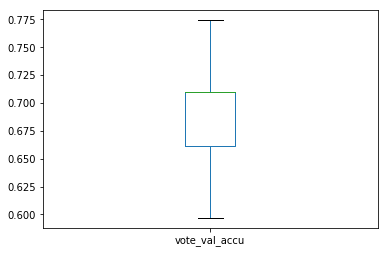

In [12]:
#by_who = ''
#x_ticks = list(set(dt[by_who]))
dtt = dt[['vote_val_accu']]
boxplot = dtt.boxplot(grid=False)
plt.suptitle("")

In [13]:
a = "/home/katieyth/gynecology/model_save/management/management_181018155330/"
# evaluate validation set
trained_model = load_model(os.path.join(a,'model.h5'))
Pred = trained_model.predict(Xtest)

Confusion matrix, without normalization
[[174  51   0]
 [ 15  65   0]
 [  5   0   0]]
Confusion matrix, without normalization
[[35 10  0]
 [ 3 13  0]
 [ 1  0  0]]
0-segment accuracy=0.7741935483870968
1-segment accuracy=0.7580645161290323
2-segment accuracy=0.7903225806451613
3-segment accuracy=0.7419354838709677
4-segment accuracy=0.7903225806451613
avg accu=0.7709677419354838
vote accu=0.7741935483870968


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


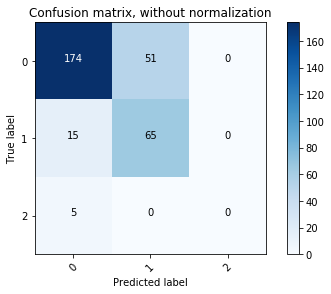

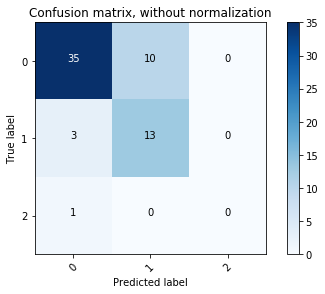

In [14]:
# evaluate by every segment
ypred_aug = np.argmax(Pred , axis=1)
ytest_aug = np.argmax(Ytest, axis=1)

cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)

plt.figure()
myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
# aggregate by voting
ypred = (np.mean(ypred_aug.reshape(FLAG.k_slice,-1), axis=0) > 0.5) + 0 # voting
ytest = np.argmax(Yvalid, axis=1)

# calculate aggregated results
cfm = confusion_matrix(y_pred=ypred, y_true=ytest)
recall = np.diag(cfm) / np.sum(cfm, axis=1)
precision = np.diag(cfm) / np.sum(cfm, axis=0)
vote_val_accu = accuracy_score(y_pred=ypred, y_true=ytest)

plt.figure()
myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
# calculate average accuracy from segments
# and voting accuracy
tmp = ypred_aug.reshape(FLAG.k_slice,-1)
savg_val_accu = 0.0
for i in range(tmp.shape[0]):
    accu = accuracy_score(y_pred=tmp[i,:], y_true=ytest)
    print('{0}-segment accuracy={1}'.format(i, accu))
    savg_val_accu += accu
savg_val_accu /= tmp.shape[0]
print('avg accu={0}'.format(savg_val_accu))
print('vote accu={0}'.format(vote_val_accu))

In [15]:
# monitor : val_loss vs val_acc

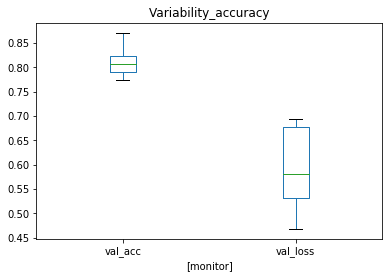

In [44]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/variability/summary_variability.csv')
log.index = log['model_id']
P1 = log.loc['variability_181018154102':'variability_181018155534'] # val_loss
P2 = log.loc['variability_181018120232':'variability_181018123513'] # val_acc
dt = pd.concat([P1,P2])
by_who = 'monitor'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Variability_accuracy")
plt.suptitle("")

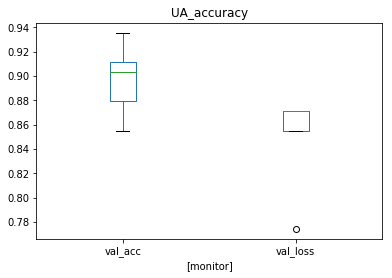

In [45]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/UA/summary_UA.csv')
log.index = log['model_id']
P1 = log.loc['UA_181018154117':'UA_181018155607'] # val_loss
P2 = log.loc['UA_181018120540':'UA_181018123526'] # val_acc
dt = pd.concat([P1,P2])

by_who = 'monitor'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("UA_accuracy")
plt.suptitle("")

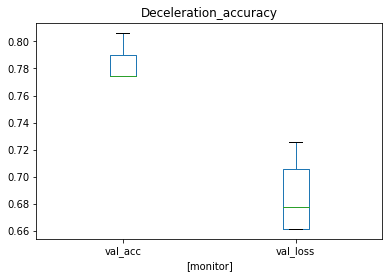

In [47]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/deceleration/summary_deceleration.csv')
log.index = log['model_id']
P1 = log.loc['deceleration_181018170456':'deceleration_181018173037'] # val_loss
P2 = log.loc['deceleration_181018173325':'deceleration_181018180058'] # val_acc
dt = pd.concat([P1,P2])

by_who = 'monitor'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Deceleration_accuracy")
plt.suptitle("")

In [20]:
# data augmentation : original vs original + fliplr 

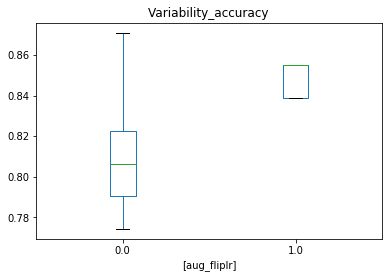

In [4]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/variability/summary_variability.csv')
log.index = log['model_id']
P1 = log.loc['variability_181018120232':'variability_181018123513'] # ori
P2 = log.loc['variability_181017165711':'variability_181018115727'] # ori_fliplr
dt = pd.concat([P1,P2])

by_who = 'aug_fliplr'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Variability_accuracy")
plt.suptitle("")

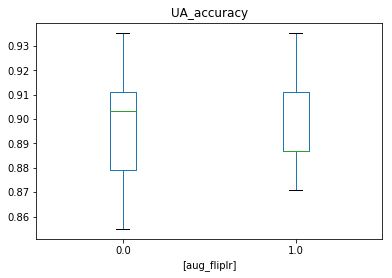

In [5]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/UA/summary_UA.csv')
log.index = log['model_id']
P1 = log.loc['UA_181018120540':'UA_181018123526'] # ori
P2 = log.loc['UA_181017165730':'UA_181018120318'] # ori_fliplr
dt = pd.concat([P1,P2])

by_who = 'aug_fliplr'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Variability_accuracy")
plt.title("UA_accuracy")
plt.suptitle("")

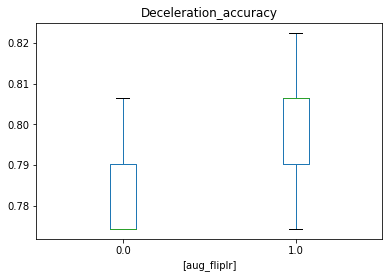

In [6]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/deceleration/summary_deceleration.csv')
log.index = log['model_id']
P1 = log.loc['deceleration_181018173325':'deceleration_181018180058'] # ori
P2 = log.loc['deceleration_181018180712':'deceleration_181018182318'] # ori_fliplr
dt = pd.concat([P1,P2])

by_who = 'aug_fliplr'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Deceleration_accuracy")
plt.suptitle("")

In [25]:
# data augmentation : 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


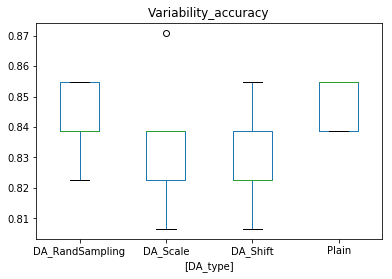

In [7]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/variability/summary_variability.csv')
log.index = log['model_id']
P0 = log.loc['variability_181017165711':'variability_181018115727']
P1 = log.loc['variability_181018170921':'variability_181018173046'] 
P2 = log.loc['variability_181019110550':'variability_181019113035'] 
P3 = log.loc['variability_181019113527':'variability_181019115522']
dt = pd.concat([P0,P1,P2,P3])

dt['DA_type'] = (dt.loc[:,'DA_RandSampling':'DA_Shift']).idxmax(1)
dt['DA_type'][dt['DA_type'].isnull()]='Plain'
idx = (dt.iloc[np.where((dt.DA_RandSampling==0) & (dt.DA_Scale==0) & (dt.DA_Shift==0))]).index
dt.loc[idx, 'DA_type'] = 'Plain'
by_who = 'DA_type'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Variability_accuracy")
plt.suptitle("")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


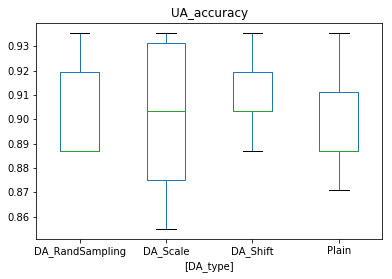

In [8]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/UA/summary_UA.csv')
log.index = log['model_id']
P0 = log.loc['UA_181017165730':'UA_181018120318']
P1 = log.loc['UA_181018170830':'UA_181018173041'] 
P2 = log.loc['UA_181019110504':'UA_181019113031'] 
P3 = log.loc['UA_181019113335':'UA_181019115057']
dt = pd.concat([P0,P1,P2,P3])

dt['DA_type'] = (dt.loc[:,'DA_RandSampling':'DA_Shift']).idxmax(1)
dt['DA_type'][dt['DA_type'].isnull()]='Plain'
idx = (dt.iloc[np.where((dt.DA_RandSampling==0) & (dt.DA_Scale==0) & (dt.DA_Shift==0))]).index
dt.loc[idx, 'DA_type'] = 'Plain'
by_who = 'DA_type'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("UA_accuracy")
plt.suptitle("")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


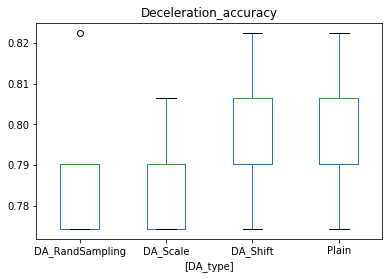

In [9]:
log = pd.read_csv('/home/katieyth/gynecology/model_save/deceleration/summary_deceleration.csv')
log.index = log['model_id']
P0 = log.loc['deceleration_181018180712':'deceleration_181018182318']
P1 = log.loc['deceleration_181019110612':'deceleration_181019113356'] 
P2 = log.loc['deceleration_181019113955':'deceleration_181019115543'] 
P3 = log.loc['deceleration_181019115845':'deceleration_181019122515']
dt = pd.concat([P0,P1,P2,P3])

dt['DA_type'] = (dt.loc[:,'DA_RandSampling':'DA_Shift']).idxmax(1)
dt['DA_type'][dt['DA_type'].isnull()]='Plain'
idx = (dt.iloc[np.where((dt.DA_RandSampling==0) & (dt.DA_Scale==0) & (dt.DA_Shift==0))]).index
dt.loc[idx, 'DA_type'] = 'Plain'
by_who = 'DA_type'
x_ticks = list(set(dt[by_who]))
dtt = dt[[by_who, 'vote_val_accu']]
boxplot = dtt.boxplot(by=by_who, grid=False)
plt.title("Deceleration_accuracy")
plt.suptitle("")

# 2018-10-26 W report
* @@@ L2
* @@@ L2 + AUG
* @@@ random seed 13 ~ 17
* XXXXXXmanagement binary or not
* managemnt pure, concat, drawout

### L2

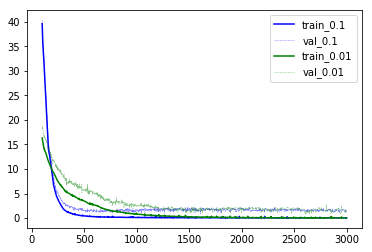

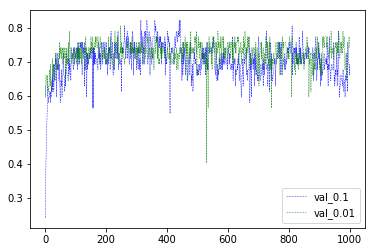

In [150]:
target = 'management' # 0.1
model_log = {#'0.5':['management_181023201557', 'c'],
            '0.1':['management_181023201624','b'],
            #'0.05':['management_181023201642','r'],
            '0.01':['management_181023201654', 'g'] 
            }
loss()
acc()

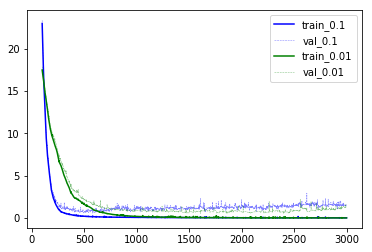

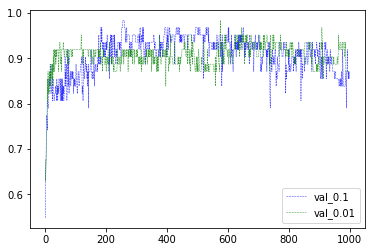

In [151]:
target = 'UA' # 0.01 
model_log = {#'0.5':['UA_181024010042', 'c'],
            '0.1':['UA_181023202759','b'],
            #'0.05':['UA_181023202815','r'],
            '0.01':['UA_181023202833', 'g']}
loss()
acc()

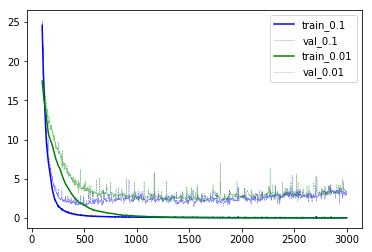

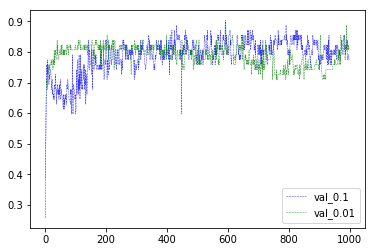

In [152]:
target = 'variability' # 0.01 
model_log = {#'0.5':['variability_181024033333', 'c'],
            '0.1':['variability_181024010717','b'],
            #'0.05':['variability_181024085347','r'],
            '0.01':['variability_181024061504', 'g']}
loss()
acc()

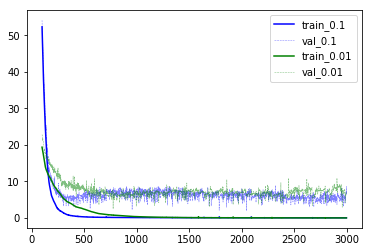

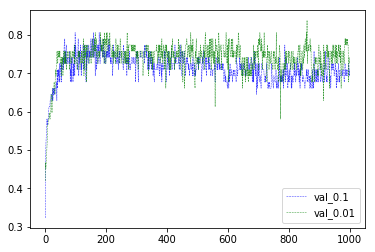

In [153]:
target = 'deceleration' # 0.01 
model_log = {#'0.5':['deceleration_181024033009', 'c'],
            '0.1':['deceleration_181024010811','b'],
            #'0.05':['deceleration_181024084723','r'],
            '0.01':['deceleration_181024061151', 'g']}
loss()
acc()

In [148]:
def loss ():
    idx1 = 100
    idx2 = 3000
    for label in model_log.keys():
        color = model_log[label][1]
        log = model_log[label][0]
        log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/%s/training.log' % (target, log))
        plt.plot(log.loc[idx1:idx2,'loss'], linestyle='-', color = color, label = 'train_%s' %(label))
        plt.plot(log.loc[idx1:idx2,'val_loss'],linestyle='--', color = color, label = 'val_%s' %(label), alpha=0.5, linewidth=0.5)
        plt.legend()
    plt.show()

In [149]:
def acc():
    idx1 = 0
    idx2 = 1000
    for label in model_log.keys():
        color = model_log[label][1]
        log = model_log[label][0]
        log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/%s/training.log' % (target, log))
        #plt.plot(log.loc[idx1:idx2,'acc'], linestyle='-', color = color, label = 'train_%s' %(label))
        plt.plot(log.loc[idx1:idx2,'val_acc'],linestyle='--', color = color, label = 'val_%s' %(label), alpha=0.8, linewidth=0.5)
        plt.legend()
    plt.show()

### L2 + aug

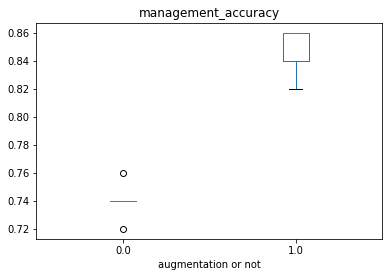

In [160]:
target = 'management' # 0.1 + aug
model_log = {'w/ -aug':['management_181024175343','management_181024195410','management_181024214610',
                        'management_181024234731','management_181025022718','management_181025144126',
                        'management_181025151603','management_181025155429','management_181025163757',
                        'management_181025171741'],
             'w/o-aug':['management_181025113342', 'management_181025120935', 'management_181025124535',
                       'management_181025132222', 'management_181025135728'] 
            }
box()

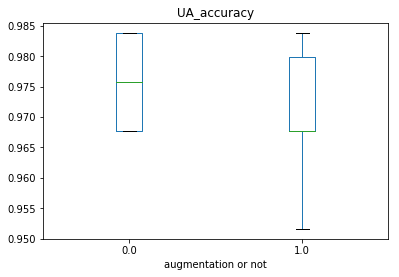

In [159]:
target = 'UA' # 0.01 
model_log = {'w/ -aug':['UA_181024103326','UA_181025144145','UA_181025151657','UA_181025155257',
                        'UA_181025163351','UA_181025171312'],
             'w/o-aug':['UA_181023202833','UA_181025113723','UA_181025121150','UA_181025124901',
                        'UA_181025132430','UA_181025135908'] 
            }
box()

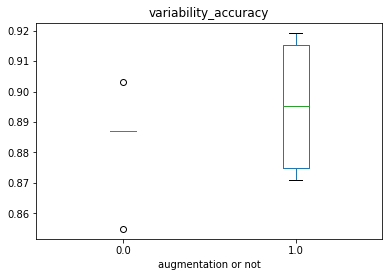

In [158]:
target = 'variability' # 0.01 
model_log = {'w/ -aug':['variability_181024130652','variability_181025144205','variability_181025151825',
                        'variability_181025155430','variability_181025163745','variability_181025171750'],
             'w/o-aug':['variability_181024061504','variability_181025113808','variability_181025121205',
                        'variability_181025124648','variability_181025132138','variability_181025135655'] 
            }
box()

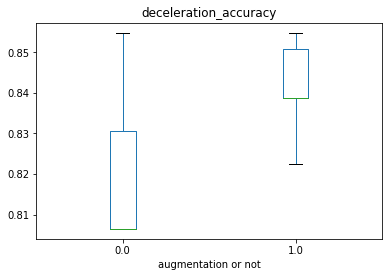

In [157]:
target = 'deceleration' # 0.01 
model_log = {'w/ -aug':['deceleration_181024130716','deceleration_181025144217','deceleration_181025151639',
                        'deceleration_181025155434','deceleration_181025163623','deceleration_181025171523'],
             'w/o-aug':['deceleration_181024061151','deceleration_181025113924','deceleration_181025121322',
                        'deceleration_181025124807','deceleration_181025132249','deceleration_181025135826',] 
            }
box()

In [4]:
def box():
    log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
    log.index = log['model_id']
    P1 = log.loc[model_log['w/ -aug']]
    P2 = log.loc[model_log['w/o-aug']] 
    dt = pd.concat([P1,P2])
    by_who = 'DA_Shift'
    # x_ticks = list(set(dt[by_who]))
    dtt = dt[[by_who, 'vote_val_accu']]
    boxplot = dtt.boxplot(by=by_who, grid=False)
    plt.title("%s_accuracy" %(target))
    plt.suptitle("")
    boxplot.set_xlabel("augmentation or not")

### random seed 13~17

In [89]:
model_log = {'UA':['UA_181024103326','UA_181024155058','UA_181024180633',
                   'UA_181024200414','UA_181024215553'],
             'variability':['variability_181024130652', 'variability_181024155024','variability_181024180913',
                             'variability_181024200604', 'variability_181024215919'],
             'deceleration':['deceleration_181024130716','deceleration_181024154911','deceleration_181024180402',
                             'deceleration_181025193355','deceleration_181024215632'],
             'management': ['management_181025171741','management_181025195402','management_181025204306',
                            'management_181025213118','management_181025222059']}

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


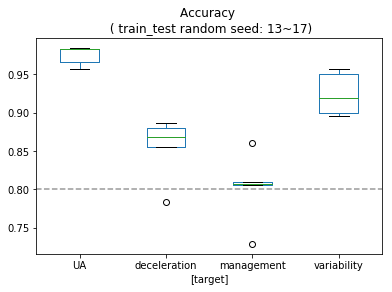

In [103]:
dt = pd.DataFrame()
for target in ['UA', 'variability', 'deceleration', 'management']:
    log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
    log.index = log['model_id']
    tmp = log.loc[model_log[target]]
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'vote_val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
#plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.title("Accuracy \n ( train_test random seed: 13~17)" )
plt.suptitle("")
plt.show()

### management

In [66]:
           'management' : ['management_181024130832',
                                'management_181024175343',
                                'management_181024195410',
                                'management_181024214610',
                                'management_181024234731',
                                'management_181025022718',
                                'management_181025144126',
                                'management_181025151603',
                                'management_181025155429',
                                'management_181025163757',
                                'management_181025171741',
                                'management_181025190429',
                                'management_181025204306',
                                'management_181025213118',
                                'management_181025222059'],
             'CNN + meta(pred)_mngment' : ['management_181025165212_concat',
                            'management_181025235926_concat']}

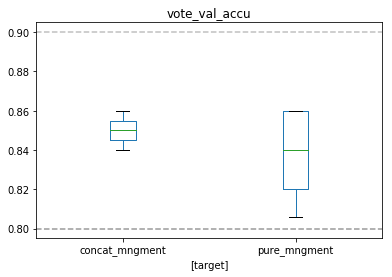

In [72]:
target = 'management'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['pure_mngment', 'concat_mngment']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'vote_val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle("")
plt.show()

# COMPARE CONCATE AND PURE: MANAGEMENT

In [5]:
target = 'management' # 0.1 + aug
model_log = {'pure_mngment':['management_181024130832',
                                'management_181024175343',
                                'management_181024195410',
                                'management_181024214610',
                                'management_181024234731',
                                'management_181025022718',
                                'management_181025144126',
                                'management_181025151603',
                                'management_181025155429',
                                'management_181025163757',
                                'management_181025171741',
                                'management_181025190429',
                                'management_181025204306',
                                'management_181025213118',
                                'management_181025222059'],
             'concat_mngment':['management_181025165212_concat',
                                'management_181025235926_concat',
                                'management_181026075213_concat',
                                'management_181026164420_concat',
                                'management_181027012608_concat'
                                ] }


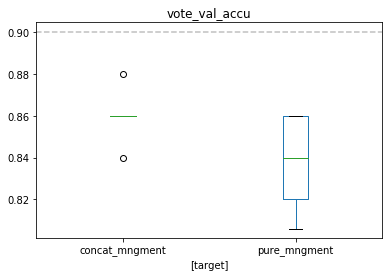

In [10]:
target = 'management'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['pure_mngment', 'concat_mngment']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'vote_val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
# plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle("")
plt.show()

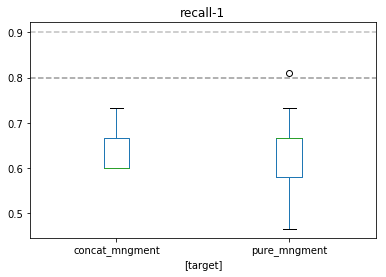

In [9]:
target = 'management'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['pure_mngment', 'concat_mngment']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'recall-1']]
boxplot = dtt.boxplot(by='target', grid=False)
plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle("")
plt.show()

# 12/28 w report

In [48]:
date = '1228'

In [49]:
target = 'management' # 0.1 + aug
model_log = {'mix':['management_181225153555',
                              'management_181225162613',
                                'management_181225171714',
                                'management_181225180838',
                                'management_181225185419'],
             'trainCTU, predictCMU':['management_181226163243',
                                'management_181226172339',
                                'management_181226181604',
                                'management_181226190828',
                                'management_181226195758'
                                ] }

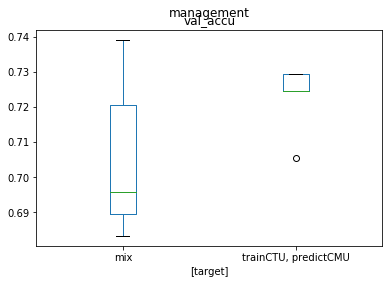

In [50]:
target = 'management'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['mix', 'trainCTU, predictCMU']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
# plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
# plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle("management")

plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'management')))
plt.show()
plt.close()

In [57]:
model_log = {'mix':['UA_181225153657',
                              'UA_181225162746',
                                'UA_181225171902',
                                'UA_181225181024',
                                'UA_181225190119'],
             'trainCTU, predictCMU':['UA_181226163325',
                                'UA_181226172148',
                                'UA_181226180901',
                                'UA_181226185614',
                                'UA_181226194754'
                                ] }

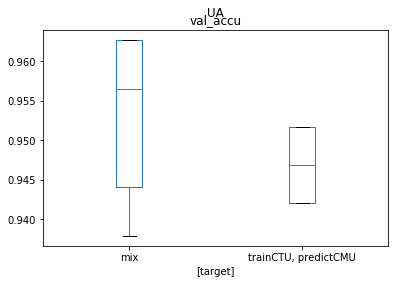

In [58]:
target = 'UA'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['mix', 'trainCTU, predictCMU']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
# plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
# plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle('UA')
plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'UA')))
plt.show()
plt.close()

In [60]:
model_log = {'mix':['variability_181225153624',
                              'variability_181225162434',
                                'variability_181225171157',
                                'variability_181225175811',
                                'variability_181225184444'],
             'trainCTU, predictCMU':['variability_181226163334',
                                'variability_181226172500',
                                'variability_181226181643',
                                'variability_181226190845',
                                'variability_181226195831'
                                ] }

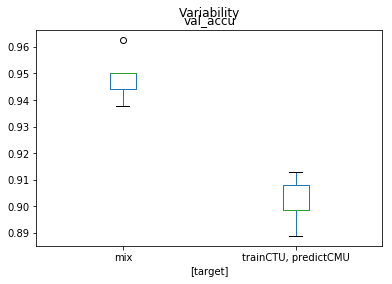

In [61]:
target = 'variability'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['mix', 'trainCTU, predictCMU']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
# plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
# plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle('Variability')
plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'var')))
plt.show()
plt.close()

In [62]:
model_log = {'mix':['deceleration_181225153736',
                              'deceleration_181225162344',
                                'deceleration_181225171033',
                                'deceleration_181225175907',
                                'deceleration_181225184939'],
             'trainCTU, predictCMU':['deceleration_181226163313',
                                'deceleration_181226171936',
                                'deceleration_181226180824',
                                'deceleration_181226185719',
                                'deceleration_181226194401'
                                ] }

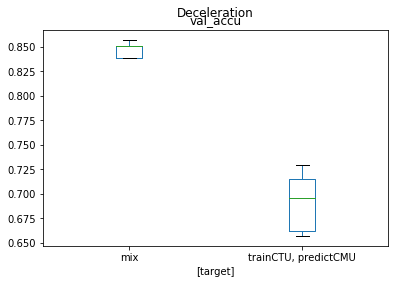

In [63]:
target = 'deceleration'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['mix', 'trainCTU, predictCMU']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])
dtt = dt[['target', 'val_accu']]
boxplot = dtt.boxplot(by='target', grid=False)
# plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
# plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
plt.suptitle('Deceleration')
plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
plt.show()
plt.close()

# 0104 W report

In [4]:
date = '0104'

In [7]:
model_log = {'multi-task:mix':['multi_190103111348',
                                'multi_190103111239',
                                'multi_190103125517',
                                'multi_190103125818',
                                'multi_190103143434',
                               'multi_190103144531',
                               'multi_190103161209',
                               'multi_190103163148',
                               'multi_190103175453',
                               'multi_190103181705'
                                ],
             'multi-task:cmu':['multi_190104111625',
                              'multi_190104111609',
                               'multi_190104111537',
                                'multi_190104125128',
                                'multi_190104125002',
                                'multi_190104142745',
                              'multi_190104143335',
                              'multi_190104161240',
                              'multi_190104161016',
                              'multi_190104174901',
                              'multi_190104175339'] ,
            'multi-task:ctu':['multi_190104175218',
                             'multi_190104175142',
                             'multi_190104190933',
                             'multi_190104191928',
                             'multi_190104204518',
                             'multi_190104210331',
                             'multi_190104222209',
                             'multi_190104225122',
                             'multi_190105000020',
                             'multi_190105003425']}

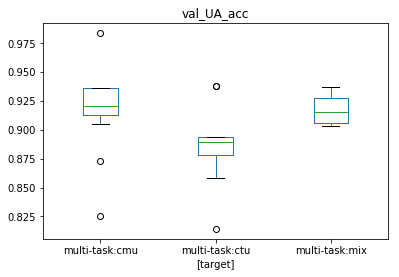

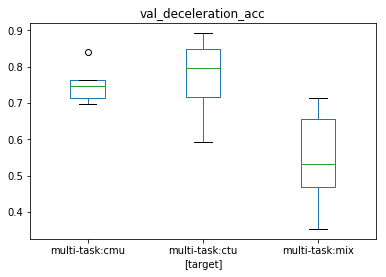

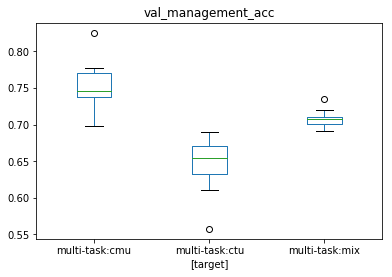

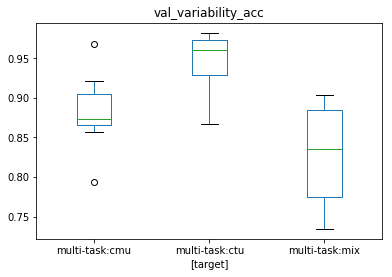

In [11]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['multi-task:mix', 'multi-task:cmu', 'multi-task:ctu']:   
# for target in ['multi-task:mix', 'multi-task:cmu']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc', 'val_management_acc', 'val_variability_acc']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

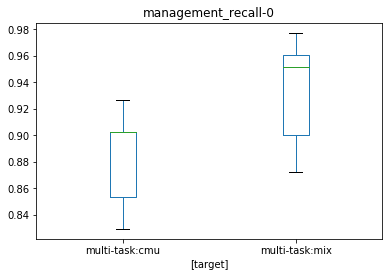

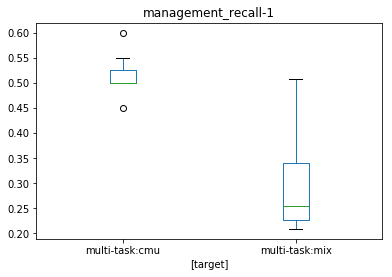

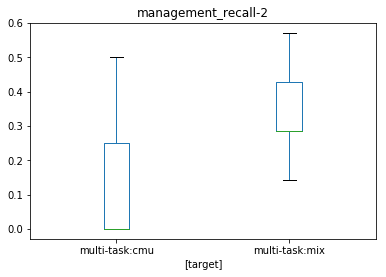

In [28]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['multi-task:mix', 'multi-task:cmu']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['management_recall-0', 'management_recall-1', 'management_recall-2']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

In [21]:
model_log = {'w/ WB':['multi_190103111239',
                                'multi_190103125818',
                                'multi_190103144531',
                                'multi_190103163148',
                                'multi_190103181705'
                                ],
             'w/o WB':['multi_190103111348',
                              'multi_190103125517',
                                'multi_190103143434',
                                'multi_190103161209',
                                'multi_190103175453'] }

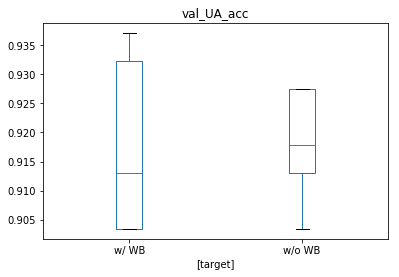

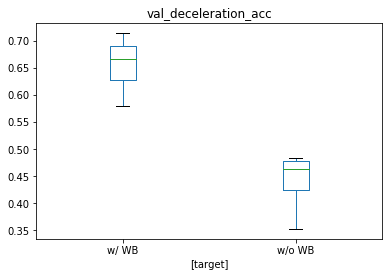

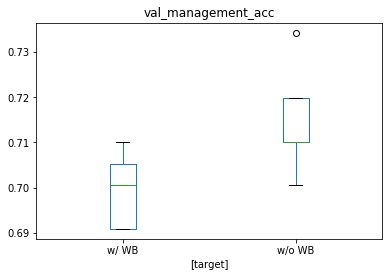

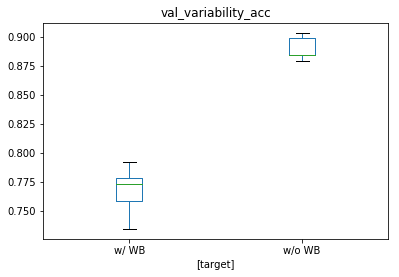

In [22]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc', 'val_management_acc', 'val_variability_acc']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

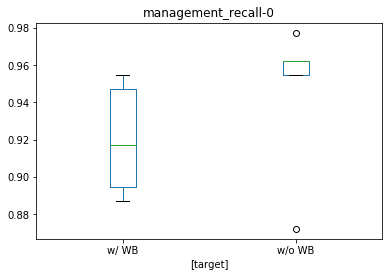

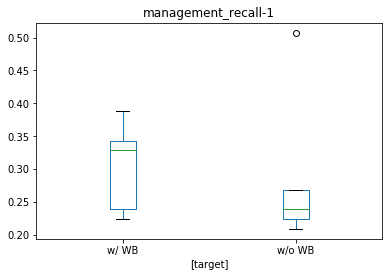

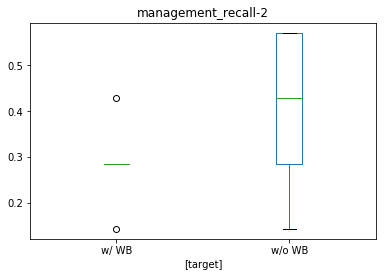

In [23]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['management_recall-0', 'management_recall-1', 'management_recall-2']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

In [12]:
model_log = {'w/ WB':['multi_190104111625',
                              'multi_190104125002',
                                'multi_190104143335',
                     'multi_190104161240',
                     'multi_190104174901'],
             'w/o WB':['multi_190104111609',
                                'multi_190104111537',
                                'multi_190104125128',
                                'multi_190104142745',
                      'multi_190104161016'] }

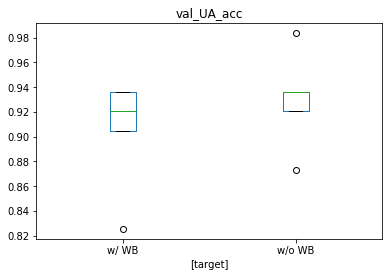

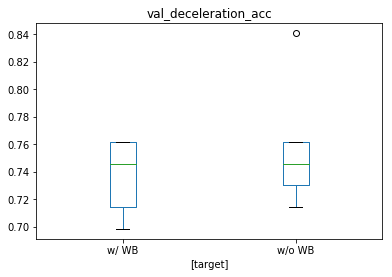

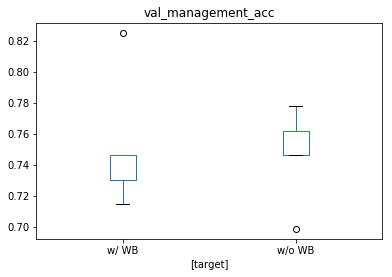

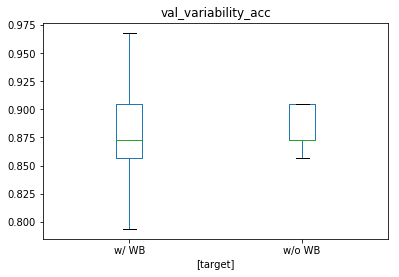

In [13]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc', 'val_management_acc', 'val_variability_acc']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

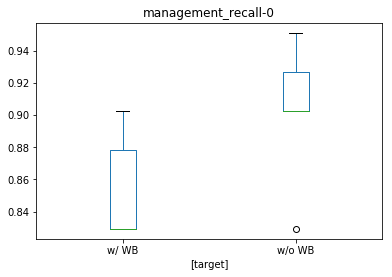

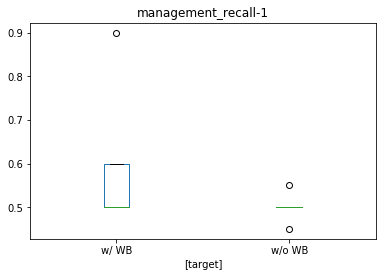

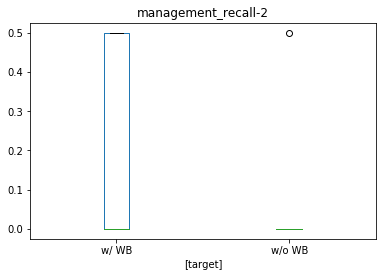

In [14]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['management_recall-0', 'management_recall-1', 'management_recall-2']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

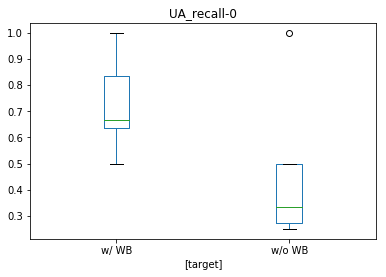

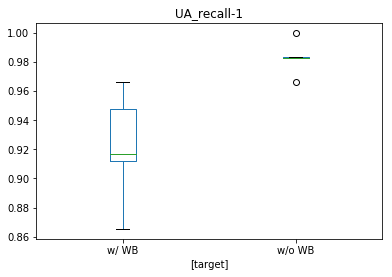

In [15]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['UA_recall-0', 'UA_recall-1']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

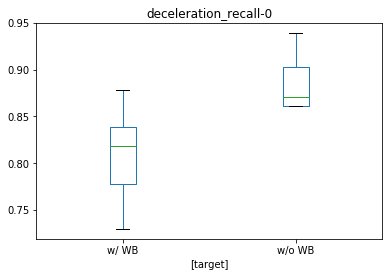

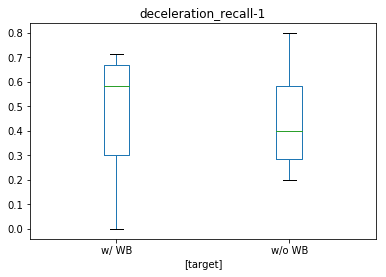

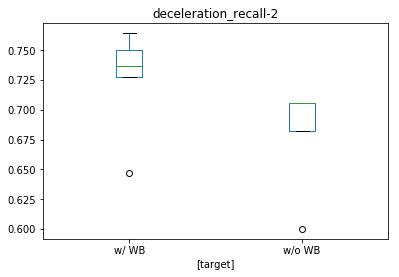

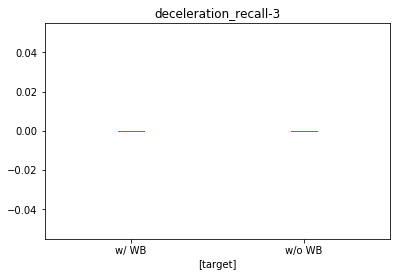

In [16]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['deceleration_recall-0', 'deceleration_recall-1','deceleration_recall-2', 'deceleration_recall-3']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

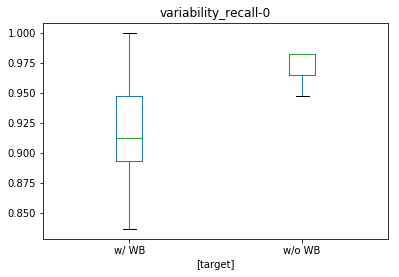

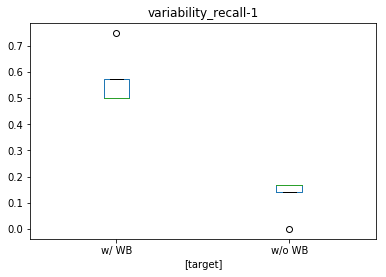

In [18]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['w/ WB', 'w/o WB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['variability_recall-0', 'variability_recall-1']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

# Final Present

## first EXP

In [52]:
date = '180117'

In [53]:
model_log = {'multi-tasking':[
#     'multi_190117125537',
                             'multi_190117131626',
                             'multi_190117133309',
                             'multi_190117135214',
#                              'multi_190117140913',
#                              'multi_190117142248',
                             'multi_190117143349',
                             'multi_190117144713',
                             'multi_190117150318',
#                              'multi_190117152425'
],
             '+concat(in model)':[
#                  'multi_190117132926',
                                 'multi_190117135040',
                                 'multi_190117140749',
                                 'multi_190117142719',
#                                  'multi_190117144355',
#                                  'multi_190117155433',
                                 'multi_190117161745',
                                 'multi_190117164008',
                                 'multi_190117165927',
#                                  'multi_190117171951'
             ],
                                 
             '+FHB':[
#                  'multi_190117113348',
                     'multi_190117115336',
                     'multi_190117121702',
                     'multi_190117123800',
#                      'multi_190117130003',
#                      'multi_190117132050',
                     'multi_190117133429',
                     'multi_190117135718',
                     'multi_190117141327',
#                      'multi_190117142848'
             ],
             # 10 - 5
            'only FHB':[
#                 'multi_190117165205',
                        'multi_190117171020',
                        'multi_190117172803',
                        'multi_190117174749',
#                         'multi_190117181608',
#                         'multi_190117183354',
                        'multi_190117185250',
                        'multi_190117190853',
                        'multi_190117193446',
#                         'multi_190117195615'
                       ]}

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


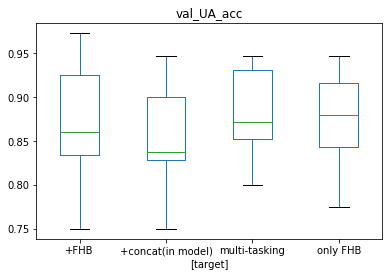

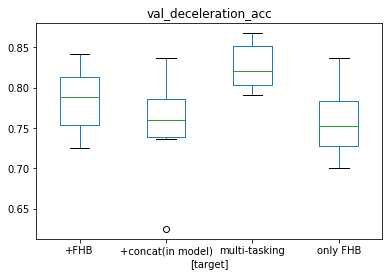

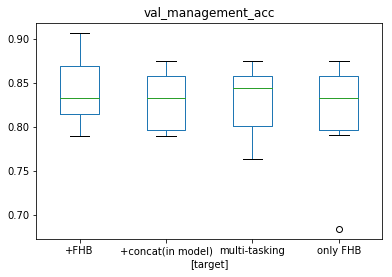

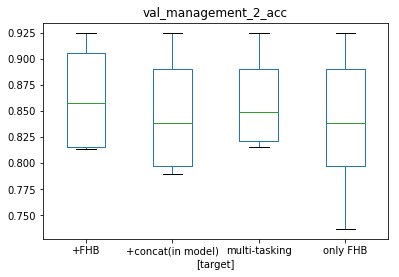

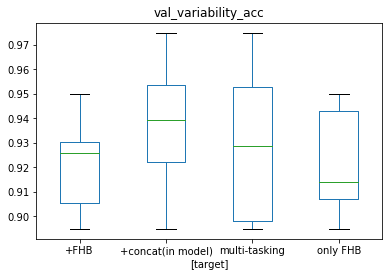

In [54]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['multi-tasking', '+concat(in model)', '+FHB', 'only FHB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc',
             'val_management_acc','val_management_2_acc',
             'val_variability_acc']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


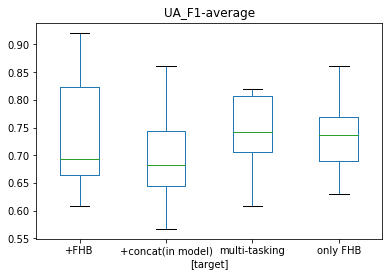

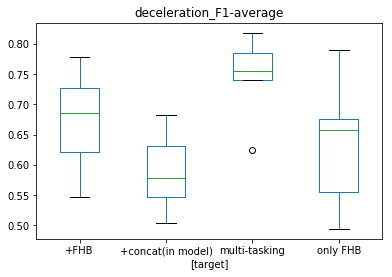

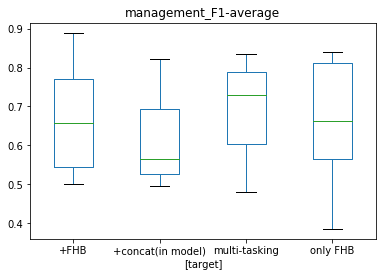

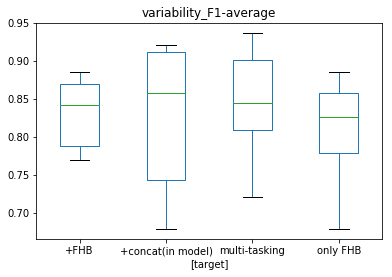

In [55]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['multi-tasking', '+concat(in model)', '+FHB', 'only FHB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['UA_F1-average', 'deceleration_F1-average',
             'management_F1-average', 'variability_F1-average']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

## second EXP

In [56]:
date = '180118'

In [57]:
model_log = {'multi-tasking':[
#     'multi_190117202940',
                             'multi_190117204709',
                             'multi_190117210632',
                             'multi_190117212626',
#                               'multi_190117215854',
#                               'multi_190117221758',
                              'multi_190117223716',
                              'multi_190117225417',
                              'multi_190117231119',
#                               'multi_190117233408'
                             ],

             '+concat(in model)':[
#                  'multi_190117234717',
                                  'multi_190118001454',
                                  'multi_190118003556',
                                  'multi_190118010705',
#                                   'multi_190118012650',
#                                   'multi_190118014528',
                                  'multi_190118015740',
                                  'multi_190118021723',
                                  'multi_190118023733',
#                                   'multi_190118025431'
                                 ],
                                 
             '+FHB':[
#                  'multi_190118031113',
                     'multi_190118033218',
                     'multi_190118040159',
                     'multi_190118042251',
#                      'multi_190118045049',
#                      'multi_190118051139',
                     'multi_190118053236',
                     'multi_190118055416',
                     'multi_190118061138',
#                      'multi_190118104341'
                     ],
             # 10 - 5
            'only FHB':[
#                 'multi_190118110410',
                        'multi_190118112402',
                        'multi_190118115029',
                        'multi_190118121434',
#                         'multi_190118123213',
#                         'multi_190118125119',
                        'multi_190118130703',
                        'multi_190118132921',
                        'multi_190118134502',
#                         'multi_190118140740'
                       ]}

In [63]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
# for target in ['multi-tasking', '+concat(in model)', '+FHB', 'only FHB']:  
for target in ['multi-tasking',  'only FHB']: 
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc',
             'val_management_acc','val_management_2_acc',
             'val_variability_acc']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: '+ FHB'

In [64]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
# for target in ['multi-tasking', '+concat(in model)', '+FHB', 'only FHB']: 
for target in ['multi-tasking',  'only FHB']: 
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['UA_F1-average', 'deceleration_F1-average',
             'management_F1-average', 'variability_F1-average']: 
    dtt = dt[['target', matx]]
    boxplot = dtt.boxplot(by='target', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: '+ FHB'

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


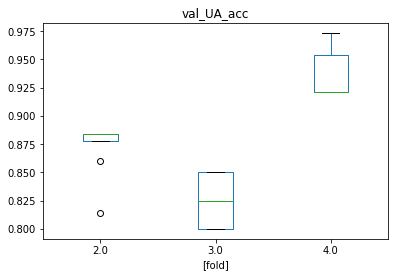

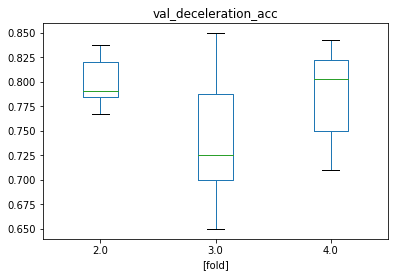

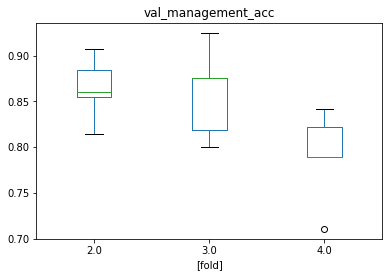

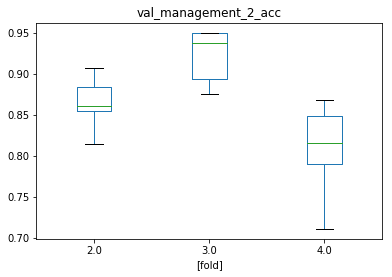

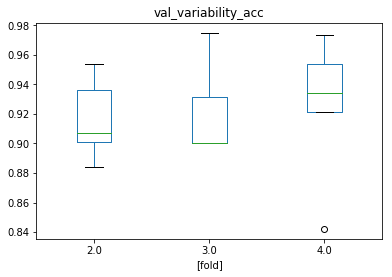

In [60]:
target = 'multi'
log = pd.read_csv('/home/katieyth/gynecology/model_save/%s/summary_%s.csv' %(target,target))
log.index = log['model_id']
dt = pd.DataFrame()
for target in ['multi-tasking', '+concat(in model)', '+FHB', 'only FHB']:   
    tmp = log.loc[model_log[target]]
    tmp['target'] = target
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc',
             'val_management_acc','val_management_2_acc',
             'val_variability_acc']: 
    dtt = dt[['fold', matx]]
    boxplot = dtt.boxplot(by='fold', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

# Exp x

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


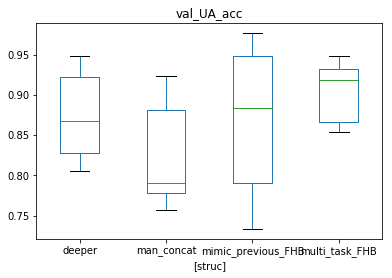

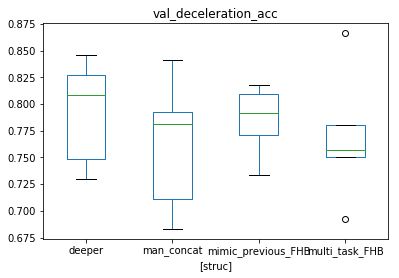

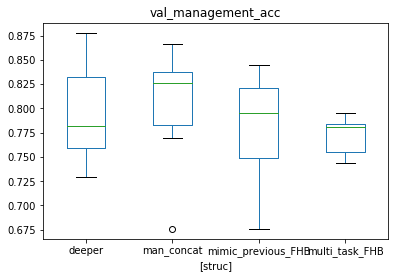

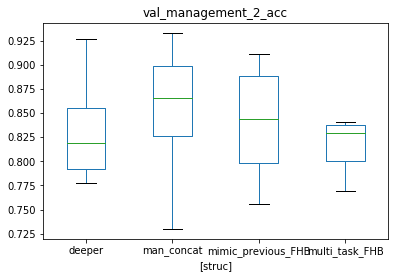

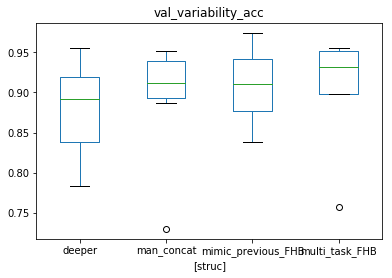

In [69]:
dt = pd.DataFrame()
for target in ['A','B','C','D']:   
    tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp0_%s.csv'%(target))
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc',
             'val_management_acc','val_management_2_acc',
             'val_variability_acc']: 
    dtt = dt[['struc', matx]]
    boxplot = dtt.boxplot(by='struc', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


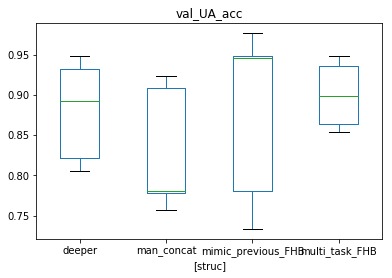

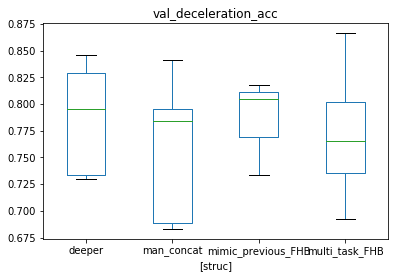

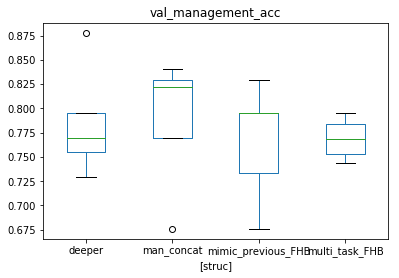

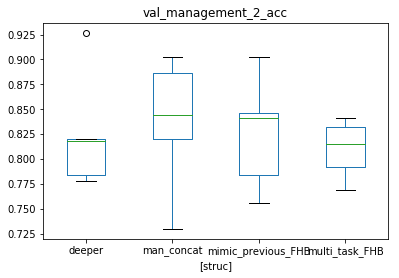

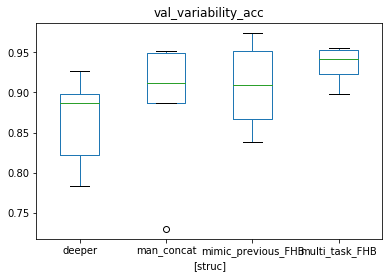

In [67]:
dt = pd.DataFrame()
for target in ['A','B','C','D']:   
    tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp0_%s.csv'%(target))
    dt = pd.concat([dt, tmp])

for matx in ['val_UA_acc', 'val_deceleration_acc',
             'val_management_acc','val_management_2_acc',
             'val_variability_acc']: 
    dtt = dt[['struc', matx]]
    boxplot = dtt.boxplot(by='struc', grid=False)
    # plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    # plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.suptitle('')
    plt.savefig(os.path.join('./w_report','%s_%s_cm.png' %(date, 'dec')))
    plt.show()
    plt.close()

# Exp0_random state(13)

In [136]:
date = '190119'

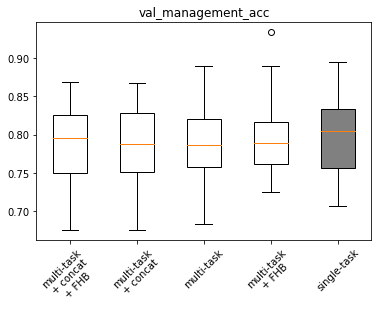

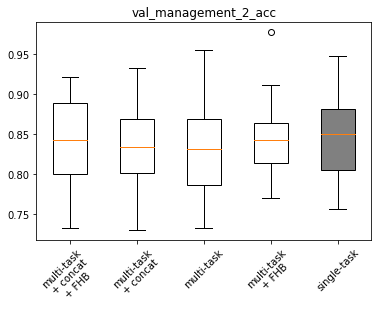

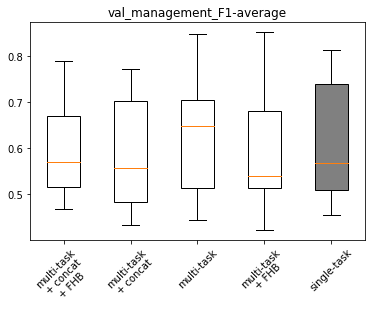

In [182]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
label_list = ['multi-task\n+ concat\n+ FHB','multi-task\n+ concat','multi-task', 'multi-task\n+ FHB', 'single-task']
color_list = ['white', 'white','white','white','gray']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    box_list = []
    for target in ['A','B','C','D','E']:
        if target =='E':
            tmp = pd.read_csv('/home/katieyth/gynecology/model_save/management/summary_management_Exp0_%s.csv'%(target))
        else:
            tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp0_%s.csv'%(target))
        dtt = tmp[['struc', matx]]
        box_list.append(dtt[matx])
    bp1 = ax.boxplot(box_list, labels = label_list, patch_artist=True)
    ax.set_xticklabels(labels = label_list,rotation=45, fontsize=10)
    for idxx, box in enumerate(bp1['boxes']):
#         box.set(color='blue', linewidth=1)
        box.set(facecolor = color_list[idxx])
#     plt.setp(box1["fliers"], markeredgecolor=c2)
    ax.set_title(title_list[idx])

#     plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
#     plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)

    plt.show()
    plt.close()

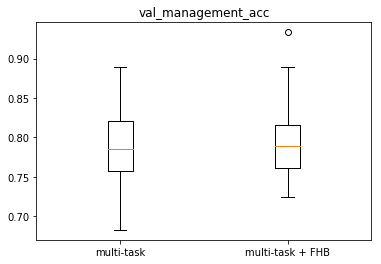

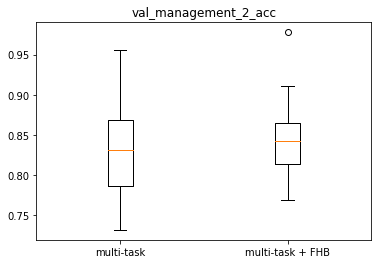

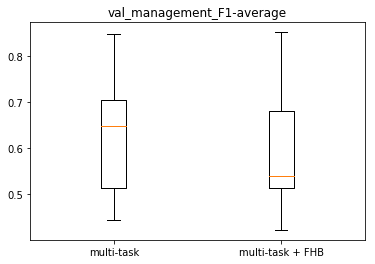

In [183]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    box_list = []
    for target in ['C','D']:
        tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp0_%s.csv'%(target))
        dtt = tmp[['struc', matx]]
        box_list.append(dtt[matx])
    bp1 = ax.boxplot(box_list, labels = ['multi-task', 'multi-task + FHB'])
    ax.set_title(title_list[idx])

#     plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
#     plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)

    plt.show()
    plt.close()

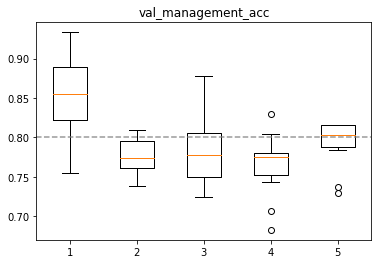

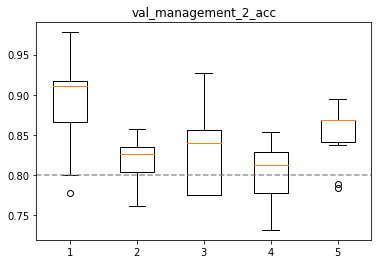

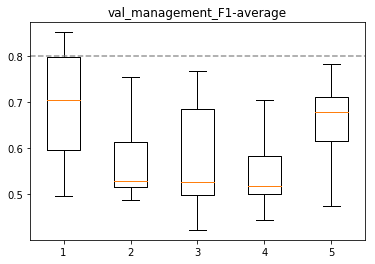

In [187]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    
    dt_apd = pd.DataFrame()
    for target in ['C','D']:
        tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp0_%s.csv'%(target))
        dtt = tmp[['fold', matx]]
        dt_apd = pd.concat([dt_apd, dtt])

    draw_list = []
    for i in [1,2,3,4,5]:
        dttt = dt_apd[dt_apd['fold'] ==i]
        draw_list.append(dttt[matx])
    ax.boxplot(draw_list)
    ax.set_title(title_list[idx])
#     plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
    plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    plt.show()
    plt.close()

# Exp1_random state(14)

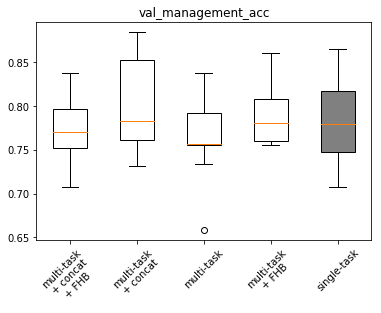

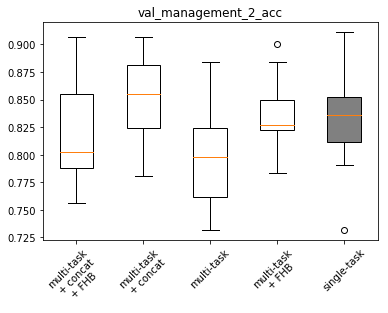

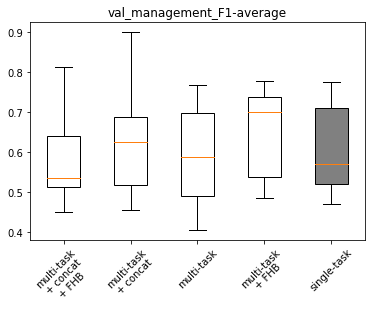

In [179]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
label_list = ['multi-task\n+ concat\n+ FHB','multi-task\n+ concat','multi-task', 'multi-task\n+ FHB', 'single-task']
color_list = ['white', 'white','white','white','gray']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    box_list = []
    for target in ['A','B','C','D','E']:
        if target =='E':
            tmp = pd.read_csv('/home/katieyth/gynecology/model_save/management/summary_management_Exp1_%s.csv'%(target))
        else:
            tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp1_%s.csv'%(target))
        dtt = tmp[['struc', matx]]
        box_list.append(dtt[matx])
    bp1 = ax.boxplot(box_list, labels = label_list, patch_artist=True)
    ax.set_xticklabels(labels = label_list,rotation=45, fontsize=10)
    for idxx, box in enumerate(bp1['boxes']):
#         box.set(color='blue', linewidth=1)
        box.set(facecolor = color_list[idxx])
#     plt.setp(box1["fliers"], markeredgecolor=c2)
    ax.set_title(title_list[idx])

#     plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
#     plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)

    plt.show()
    plt.close()

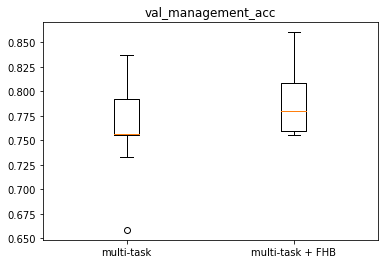

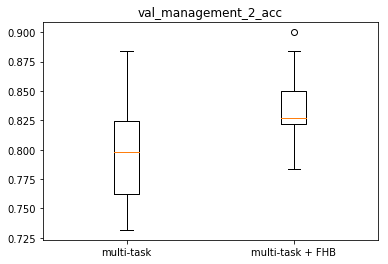

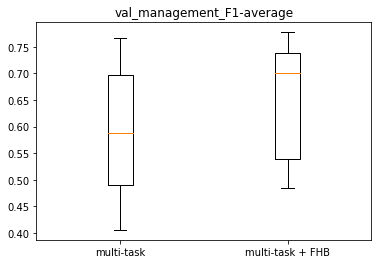

In [180]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    box_list = []
    for target in ['C','D']:
        tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp1_%s.csv'%(target))
        dtt = tmp[['fold','struc', matx]]
        box_list.append(dtt[matx])
    bp1 = ax.boxplot(box_list, labels = ['multi-task', 'multi-task + FHB'])
    ax.set_title(title_list[idx])

    plt.show()
    plt.close()

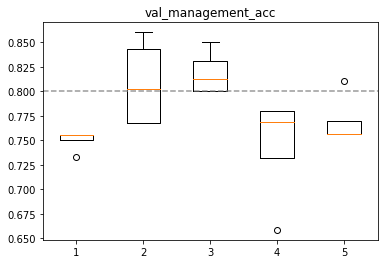

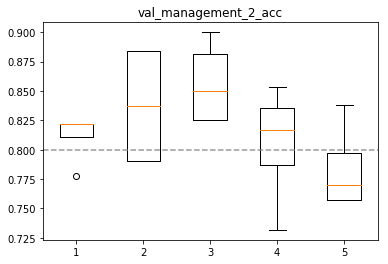

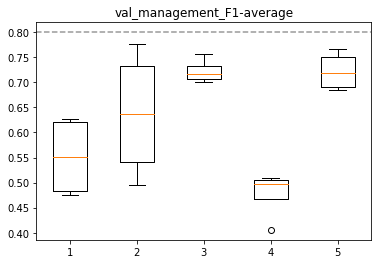

In [188]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    
    dt_apd = pd.DataFrame()
    for target in ['C','D']:
        tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp1_%s.csv'%(target))
        dtt = tmp[['fold', matx]]
        dt_apd = pd.concat([dt_apd, dtt])

    draw_list = []
    for i in [1,2,3,4,5]:
        dttt = dt_apd[dt_apd['fold'] ==i]
        draw_list.append(dttt[matx])
    ax.boxplot(draw_list)
    plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)
    ax.set_title(title_list[idx])
    plt.show()
    plt.close()

# Exp2_random state(15)

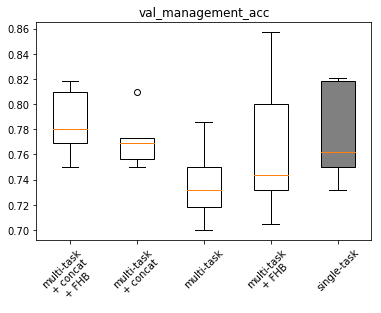

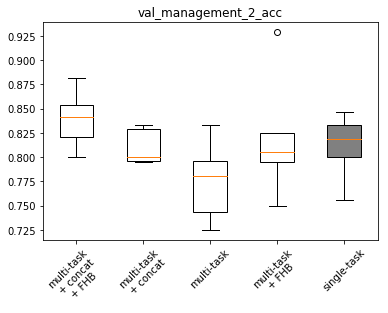

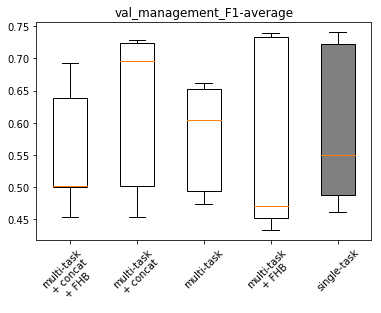

In [121]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
label_list = ['multi-task\n+ concat\n+ FHB','multi-task\n+ concat','multi-task', 'multi-task\n+ FHB', 'single-task']
color_list = ['white', 'white','white','white','gray']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    box_list = []
    for target in ['A','B','C','D','E']:
        if target =='E':
            tmp = pd.read_csv('/home/katieyth/gynecology/model_save/management/summary_management_Exp2_%s.csv'%(target))
        else:
            tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp2_%s.csv'%(target))
        dtt = tmp[['struc', matx]]
        box_list.append(dtt[matx])
    bp1 = ax.boxplot(box_list, labels = label_list, patch_artist=True)
    ax.set_xticklabels(labels = label_list,rotation=45, fontsize=10)
    for idxx, box in enumerate(bp1['boxes']):
#         box.set(color='blue', linewidth=1)
        box.set(facecolor = color_list[idxx])
#     plt.setp(box1["fliers"], markeredgecolor=c2)
    ax.set_title(title_list[idx])

#     plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
#     plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)

    plt.show()
    plt.close()

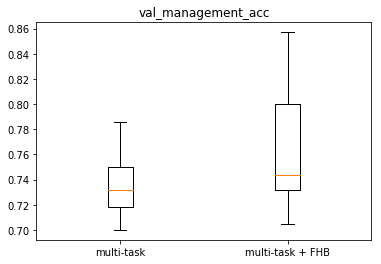

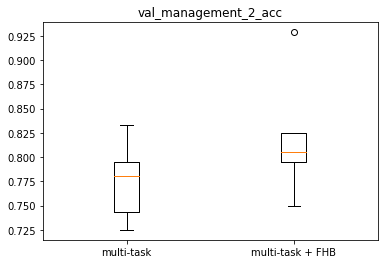

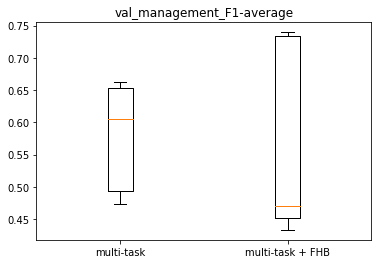

In [122]:
dt = pd.DataFrame()
title_list = ['val_management_acc','val_management_2_acc', 'val_management_F1-average']
for idx,matx in enumerate(['val_management_acc','val_management_2_acc', 'management_F1-average']): 
    fig, ax = plt.subplots()
    box_list = []
    for target in ['C','D']:
        tmp = pd.read_csv('/home/katieyth/gynecology/model_save/multi/summary_multi_Exp2_%s.csv'%(target))
        dtt = tmp[['struc', matx]]
        box_list.append(dtt[matx])
    bp1 = ax.boxplot(box_list, labels = ['multi-task', 'multi-task + FHB'])
    ax.set_title(title_list[idx])

#     plt.axhline(y=0.9, color='gray', linestyle='--', alpha = 0.5)
#     plt.axhline(y=0.8, color='gray', linestyle='--', alpha = 0.8)

    plt.show()
    plt.close()